In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
from PIL import Image
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize,Pad


from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from data_preprocess import SphericalImageRotationDataset,extract_labels_from_filename,create_transformation_matrix,vector_from_rotation,generate_pairs_with_labels,plot_image_pair_with_label
from Rotation_estimation_paper_architecture import TransformerDecoder,SiameseUNet,ExtremeRotationEstimator,QuaternionLoss

### Pair dataset creation

In [2]:
image_dir = "SphericalImages2" 
image_paths = glob.glob(os.path.join(image_dir, "*.png"))

pairs, labels = generate_pairs_with_labels(image_paths)
dataset = SphericalImageRotationDataset(pairs, labels)

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



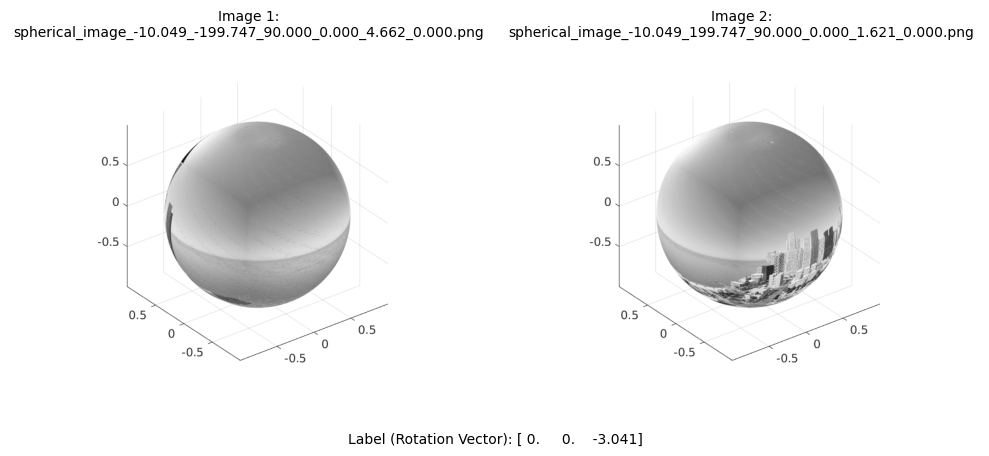

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



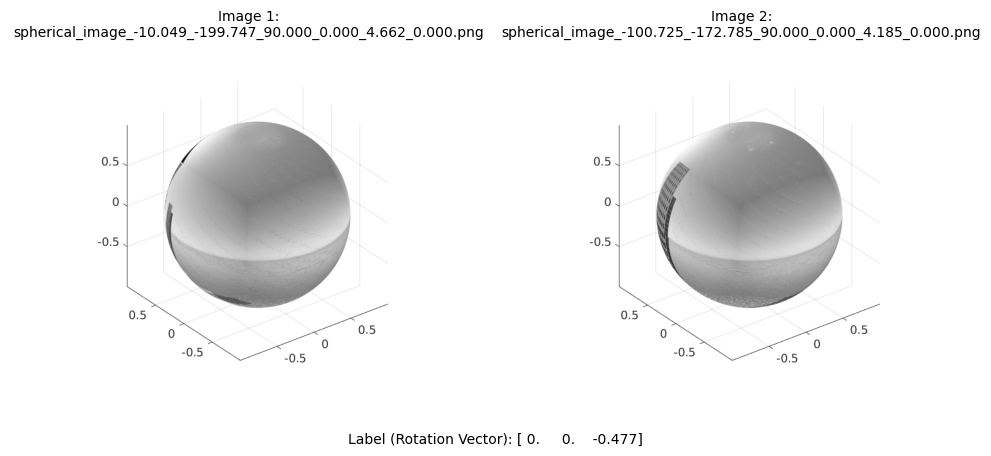

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



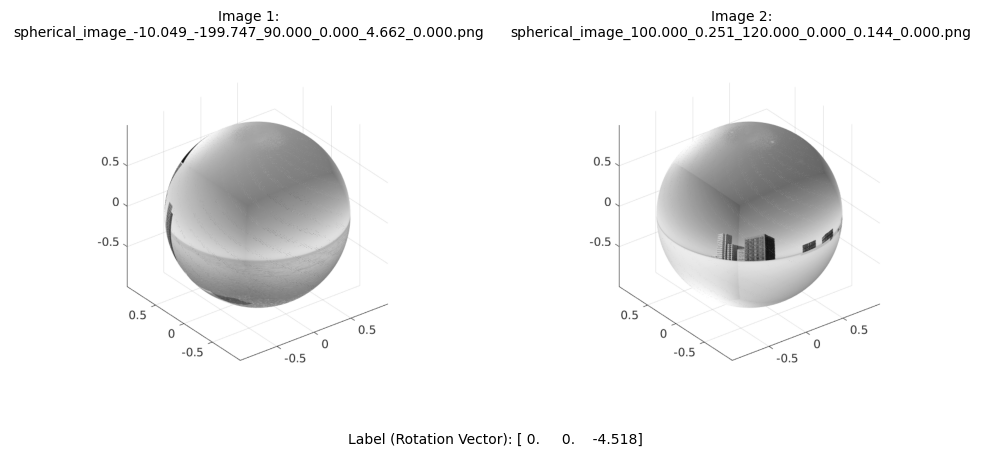

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



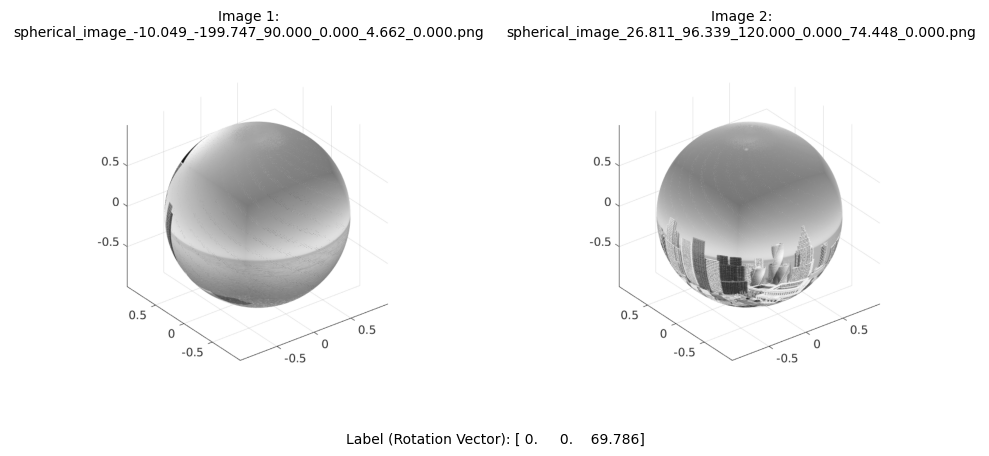

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



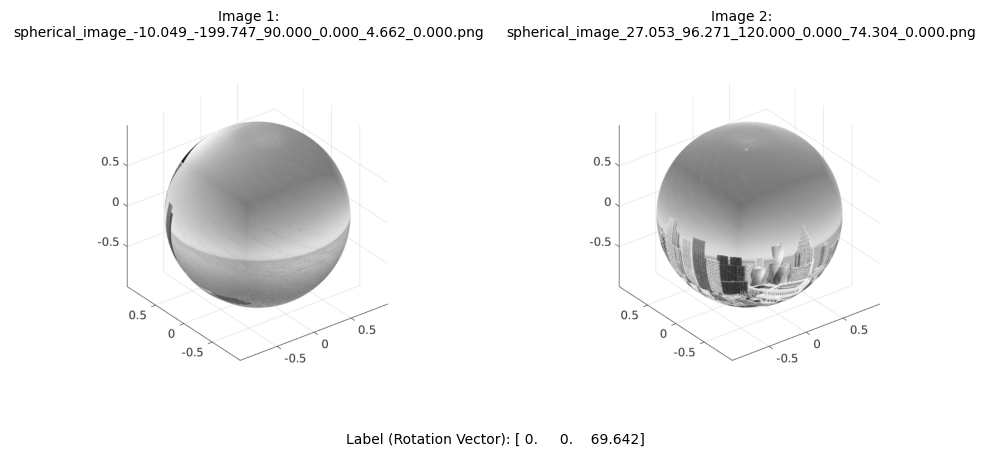

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



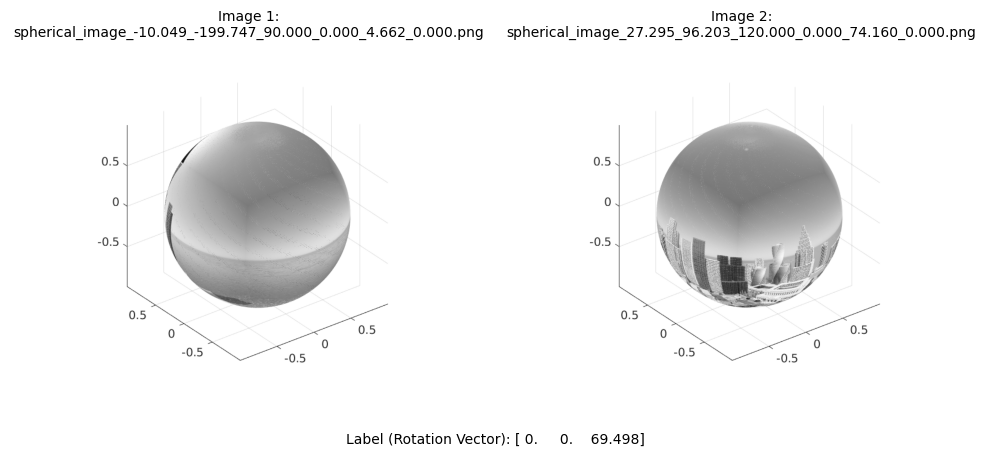

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



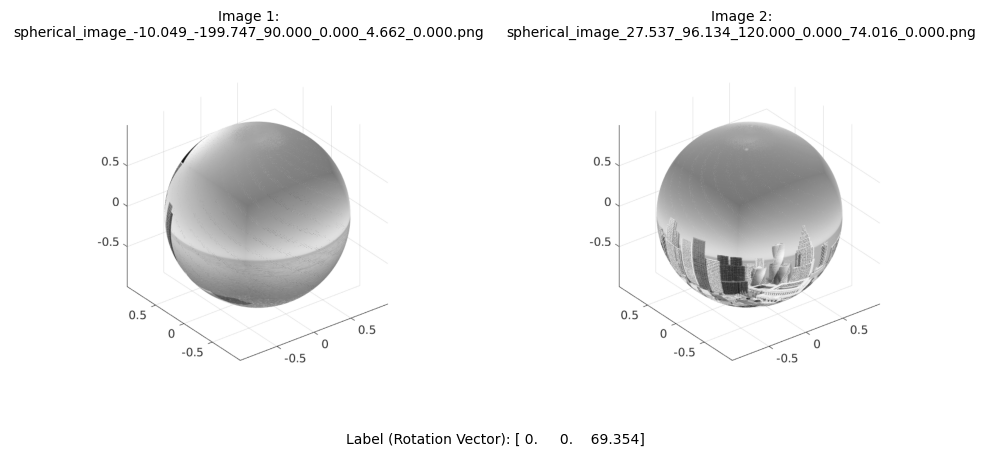

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



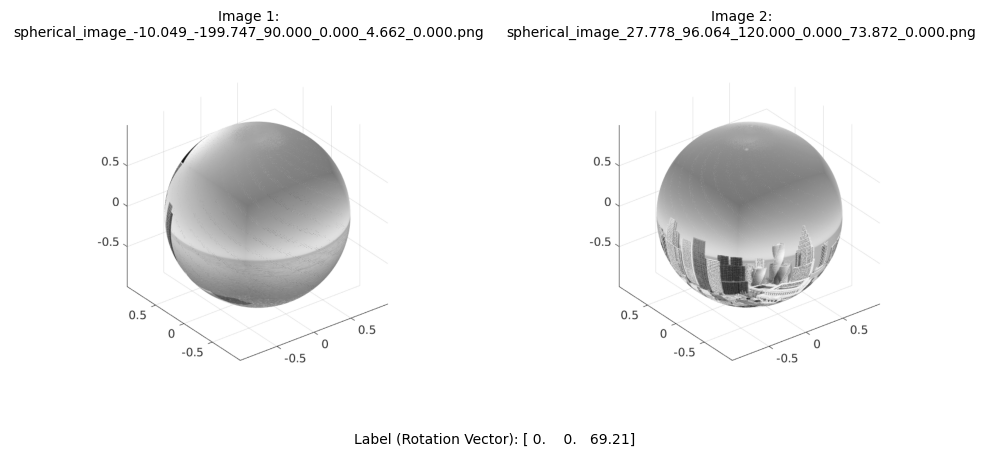

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



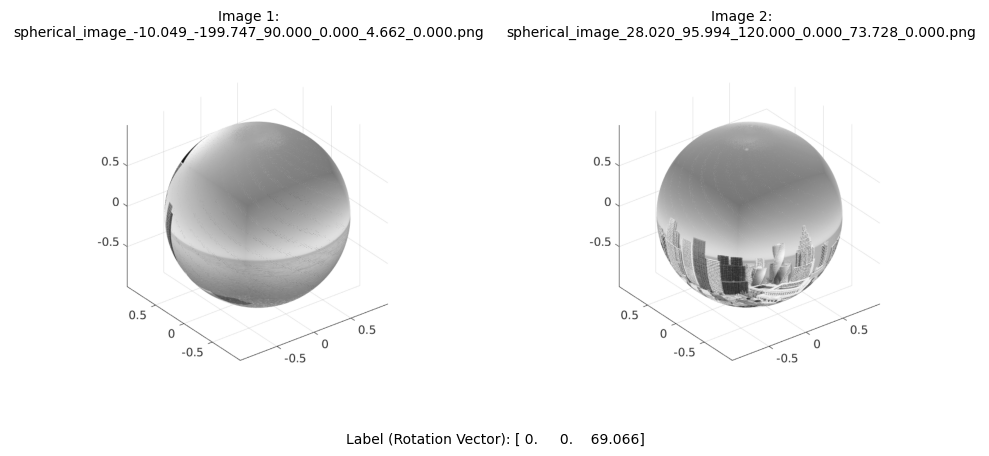

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



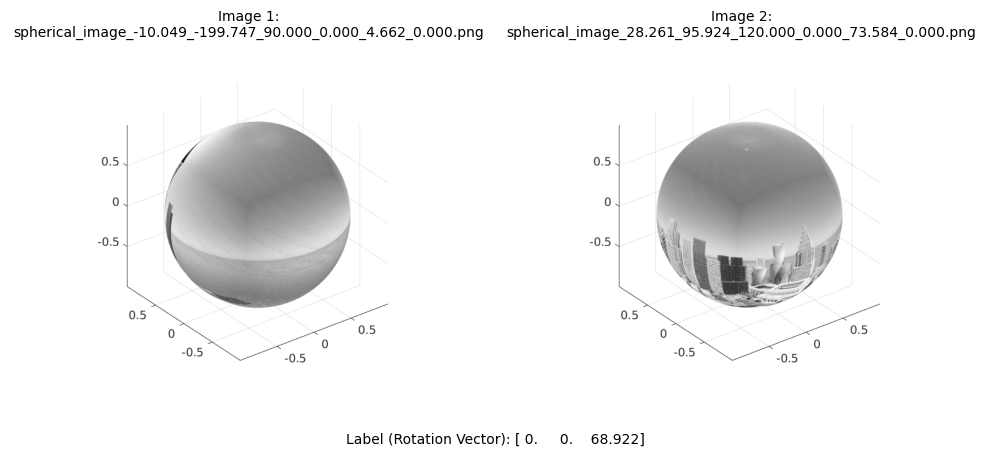

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



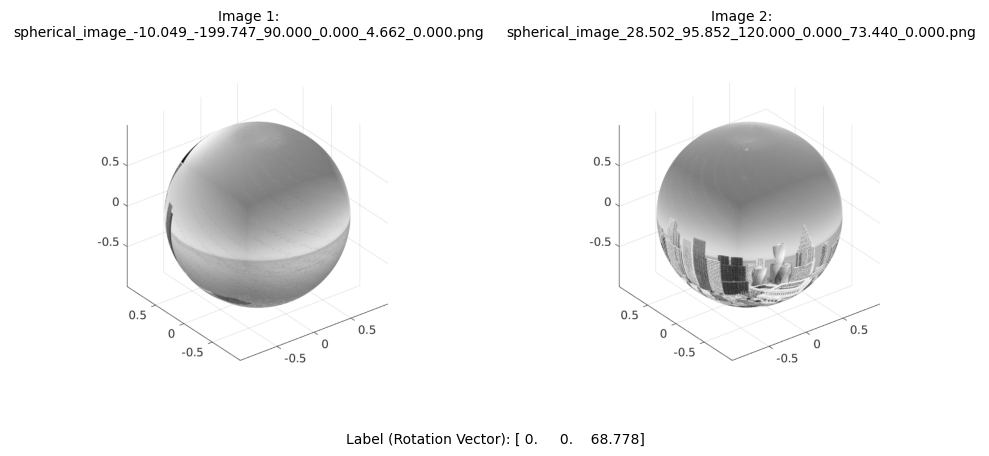

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



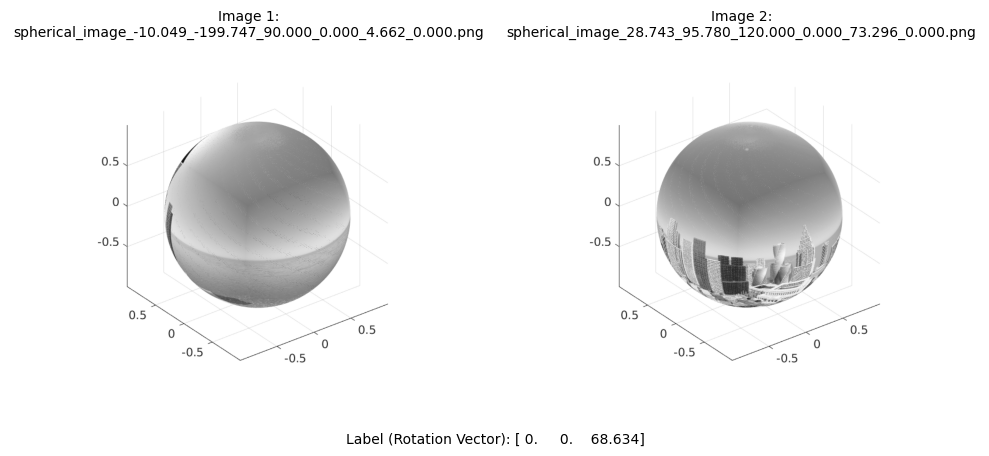

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



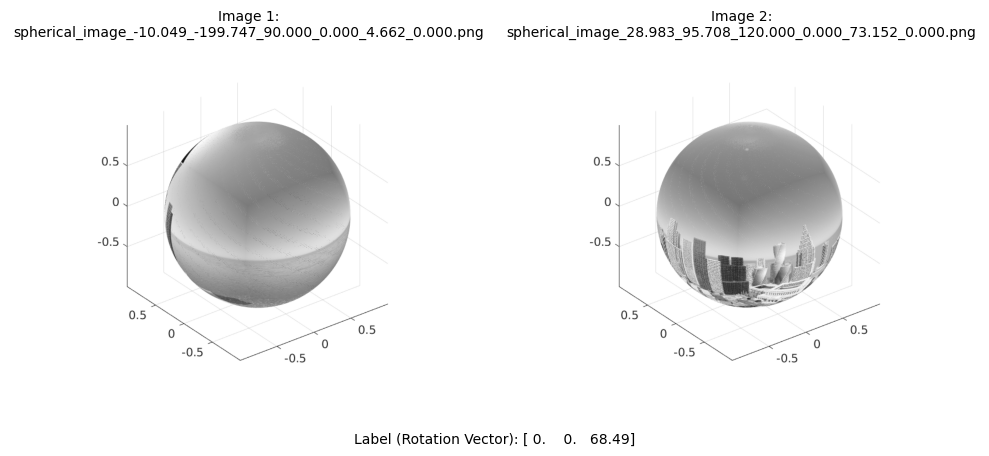

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



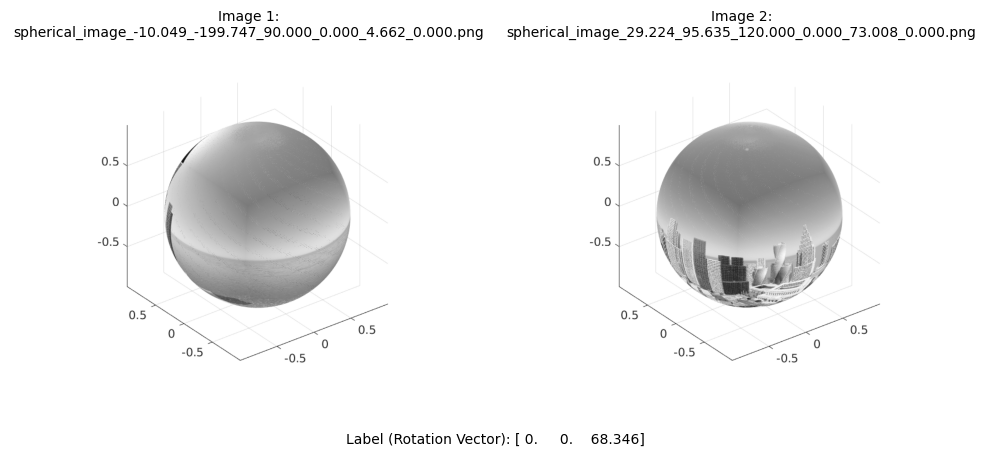

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



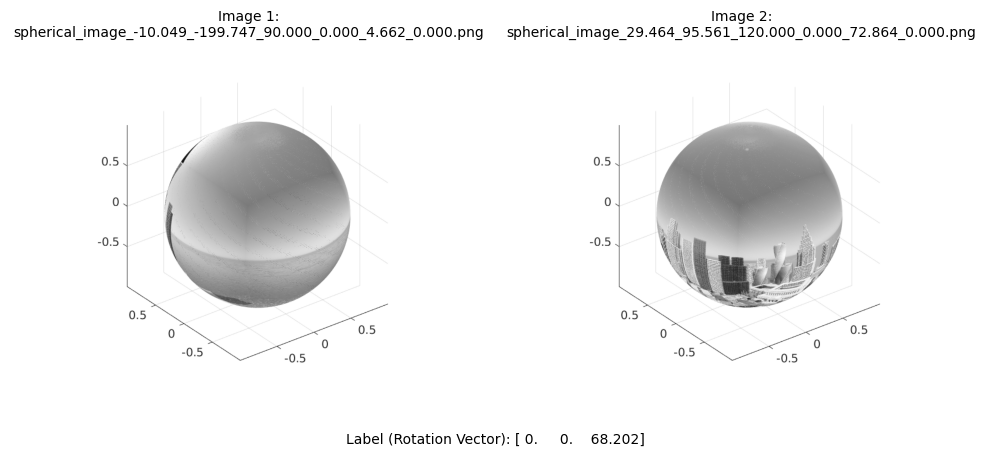

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



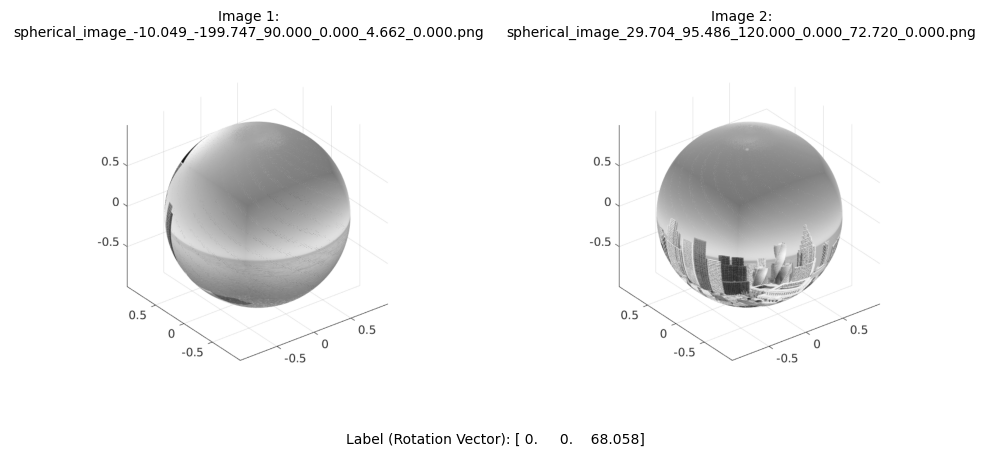

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



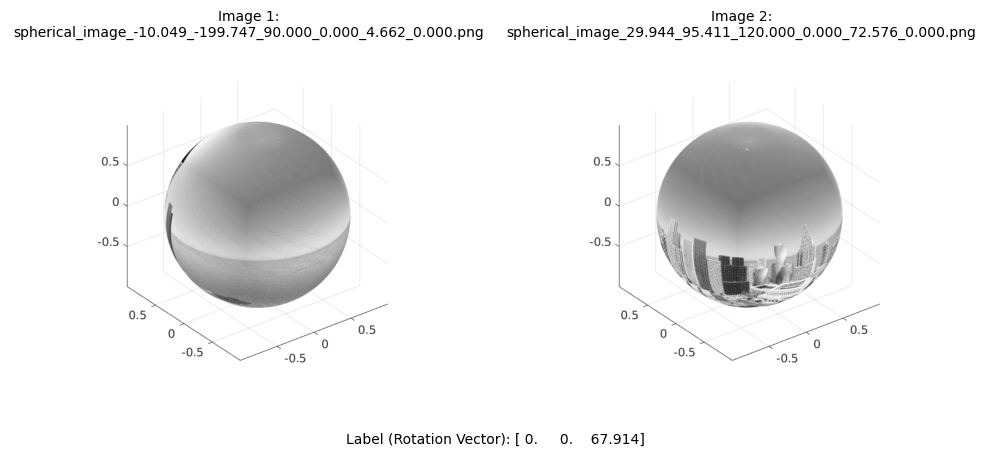

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



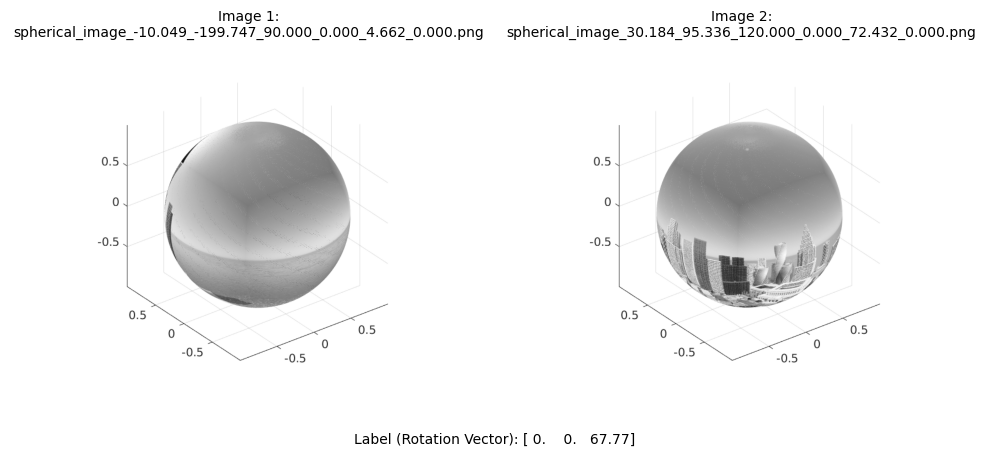

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



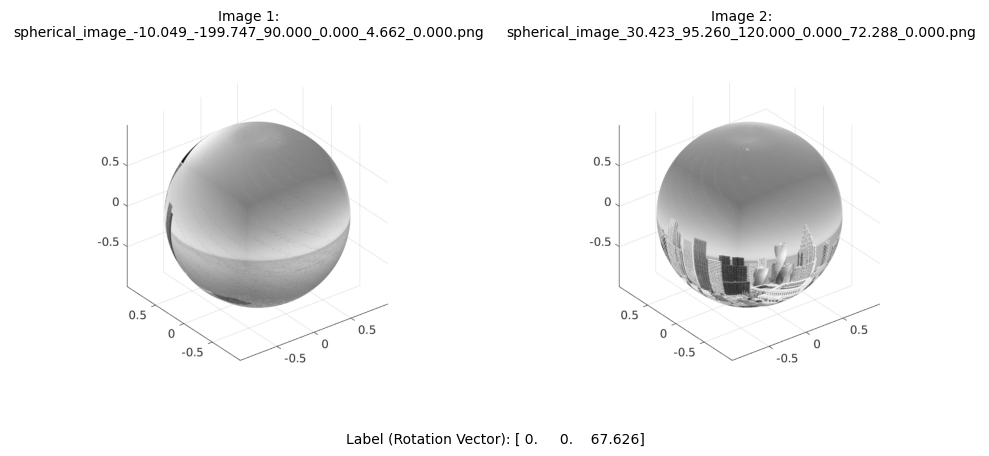

torch.Size([3, 672, 896])
torch.Size([3, 672, 896])
 torch.Size([3])



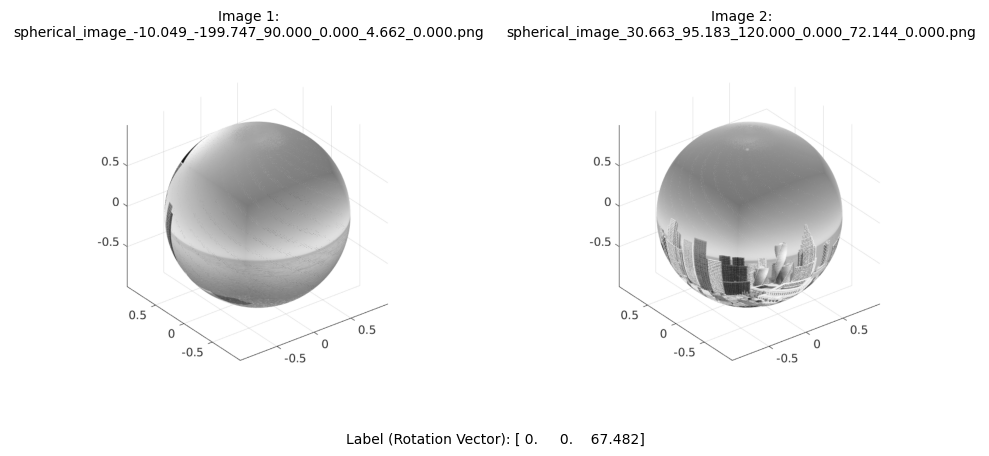

In [3]:
for i in range(20): 
    img1, img2, label = dataset[i]
    print(f"{img1.shape}")  # (width, height)
    print(f"{img2.shape}")  # (width, height)
    print(f" {label.shape if isinstance(label, torch.Tensor) else len(label)}\n")

    plot_image_pair_with_label(pairs[i][0], pairs[i][1], label.numpy())

### Train-test split and size check 

In [5]:
batch_size = 256
# Assuming `dataset` is your complete dataset
dataset_size = len(dataset)

# Calculate the sizes for train and validation splits
val_size = int(0.2 * dataset_size)  # 20% for validation
train_size = dataset_size - val_size  # Remaining 80% for training

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for both splits
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Total Dataset Size: {dataset_size}")
print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")

Total Dataset Size: 95266
Training Dataset Size: 76213
Validation Dataset Size: 19053


### Load the model architechture

In [6]:
model = ExtremeRotationEstimator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.nn.DataParallel(model)
model.to(device)
loss_function = QuaternionLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

C:\Users\mrahaman3\.conda\envs\fiz\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


### Accuracy function

In [7]:
import torch
import numpy as np

def calculate_accuracy(predicted, ground_truth, threshold_degrees=10):
    """
    Calculate accuracy based on angular difference between predicted and ground truth quaternions.
    
    Args:
        predicted (torch.Tensor): Predicted quaternions, shape (batch_size, 4).
        ground_truth (torch.Tensor): Ground truth quaternions, shape (batch_size, 4).
        threshold_degrees (float): Threshold for accuracy in degrees.
        
    Returns:
        float: Accuracy percentage.
    """
    predicted = predicted / torch.norm(predicted, dim=1, keepdim=True)
    ground_truth = ground_truth / torch.norm(ground_truth, dim=1, keepdim=True)
    
    dot_product = torch.sum(predicted * ground_truth, dim=1).clamp(-1.0, 1.0)  # Clamp to avoid numerical issues
    angles = 2 * torch.acos(torch.abs(dot_product))  # Angular difference in radians
    
    angles_degrees = angles * (180.0 / np.pi)
    
    correct_predictions = (angles_degrees <= threshold_degrees).float()
    accuracy = correct_predictions.mean().item() * 100  # Percentage
    
    return accuracy

### Load the trained weight and put model in evaluation mode

In [8]:
path =r"extreme_rotation_estimator_weights_new_loss.pth"
model = ExtremeRotationEstimator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.nn.DataParallel(model)
model.to(device)
model.load_state_dict(torch.load("extreme_rotation_estimator_weights_new_loss.pth", map_location=device))  # Load weights
model.eval()

C:\Users\mrahaman3\AppData\Local\Temp\31\ipykernel_21288\3534603606.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("extreme_rotation_es

DataParallel(
  (module): ExtremeRotationEstimator(
    (embedding_net): SiameseUNet(
      (base_model): Unet(
        (encoder): ResNetEncoder(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): BasicBlock(
              (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
        

### geodesic error calculation

In [9]:

def compute_geodesic_error(predicted_quaternions, ground_truth_quaternions):

    predicted_quaternions = predicted_quaternions / torch.norm(predicted_quaternions, dim=1, keepdim=True)
    ground_truth_quaternions = ground_truth_quaternions / torch.norm(ground_truth_quaternions, dim=1, keepdim=True)
    
    # Compute the dot product (cosine of the angle)
    dot_product = torch.abs(torch.sum(predicted_quaternions * ground_truth_quaternions, dim=1))
    
    # Clamp the dot product to avoid numerical issues
    dot_product = torch.clamp(dot_product, -1.0, 1.0)
    
    # Compute the geodesic error (in degrees)
    geodesic_error = 2 * torch.acos(dot_product) * (180.0 / torch.pi)
    return geodesic_error

def evaluate_geodesic_error(model, dataloader, device, threshold_degrees=5):

    model.eval()
    all_errors = []

    with torch.no_grad():
        for batch in dataloader:
            # Extract inputs and ground truth
            img1, img2, ground_truth_quaternions = batch
            img1, img2, ground_truth_quaternions = img1.to(device), img2.to(device), ground_truth_quaternions.to(device)
            
            # Generate a placeholder rotation query
            rotation_query = torch.zeros(img1.size(0), 3, device=device)
            # Forward pass
            predicted_quaternions = model(img1, img2, rotation_query)
            
            # Compute geodesic errors for this batch
            errors = compute_geodesic_error(predicted_quaternions, ground_truth_quaternions)
            all_errors.append(errors)

    # Concatenate errors from all batches
    all_errors = torch.cat(all_errors).cpu().numpy()
    
    # Compute metrics
    mean_error = all_errors.mean()
    median_error = np.median(all_errors)
    accuracy = (all_errors < threshold_degrees).mean() * 100  # Percentage
    
    return {
        "mean_geodesic_error": mean_error,
        "median_geodesic_error": median_error,
        "accuracy_below_threshold": accuracy
    }



In [10]:
# # Evaluate on validation/test set
threshold_degrees=10
metrics = evaluate_geodesic_error(model, val_loader, device, threshold_degrees=10)
print(f"Mean Geodesic Error: {metrics['mean_geodesic_error']:.2f}°")
print(f"Median Geodesic Error: {metrics['median_geodesic_error']:.2f}°")
print(f"{threshold_degrees}° Accuracy: {metrics['accuracy_below_threshold']:.2f}%")

Mean Geodesic Error: nan°
Median Geodesic Error: nan°
10° Accuracy: 39.86%
